<h1 style="font-size: 40px; text-align: center;">Causal Machine Learning Simulations</h1>

<h1 style="font-size: 20px; text-align: center;">(Original material by Michael C. Knaus)</h1>

<p align="center">
  <img src="https://pbs.twimg.com/media/FrGy6a5aMAAQ7u3?format=png&name=large" alt="Alt text" width="700" height="350">
</p>

# 5. Average treatment effect estimation: AIPW - Doubly Robust estimator

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
import graphviz as gr

import statsmodels.api as sm

from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression


In [2]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Restore warnings
warnings.filterwarnings("default")

import warnings

# Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")


# Reset the warnings filter if necessary
# warnings.resetwarnings()

warnings.filterwarnings("ignore", category=DeprecationWarning)

$$
\text{Identifying Assumption 2 (Strong Ignorability)}
$$

$$
\text{(a)} \quad Y(w) \perp\!\!\perp W \mid X \quad \text{for all} \quad W \in \{0,1\}
$$

$$
\text{(b)} \quad 0 < \mathbb{P}\big[W=1 \mid X \big] := e(X) < 1
$$

$$
\text{IA2b is called common support/overlap/positivity assumption.}
$$
$$
\text{It is required b/c we do not impose an outcome model that allows to extrapolate
the counterfactual into regions where everybody receives the same treatment}
$$

<!-- Add the following HTML and LaTeX code within your Markdown cell -->

<div style="text-align:center;">

$$
\begin{align*}
1. & \quad \mathbb{E}\big[Y(w) \mid X=x \big] = \mathbb{E}\big[Y \mid W=w, X=x \big] =: m(w,x) \\
2. & \quad \mathbb{E}\bigg[\frac{\mathbb{1}\big[W=w \big] Y}{e_w(x)} \mid X=x \bigg] \\
3. & \quad \mathbb{E}\bigg[m(w,x) + \frac{\mathbb{1}\big[W=w \big] (Y-m(w,x))}{e_w(x)} \mid X=x \bigg]
\end{align*}
$$

</div>

<div style="text-align:center;">

(1) motivates estimation via regression adjustment,  
(2) motivates inverse probability weighting (IPW), and  
(3) motivates the doubly robust/augmented IPW (AIPW) estimator

</div>

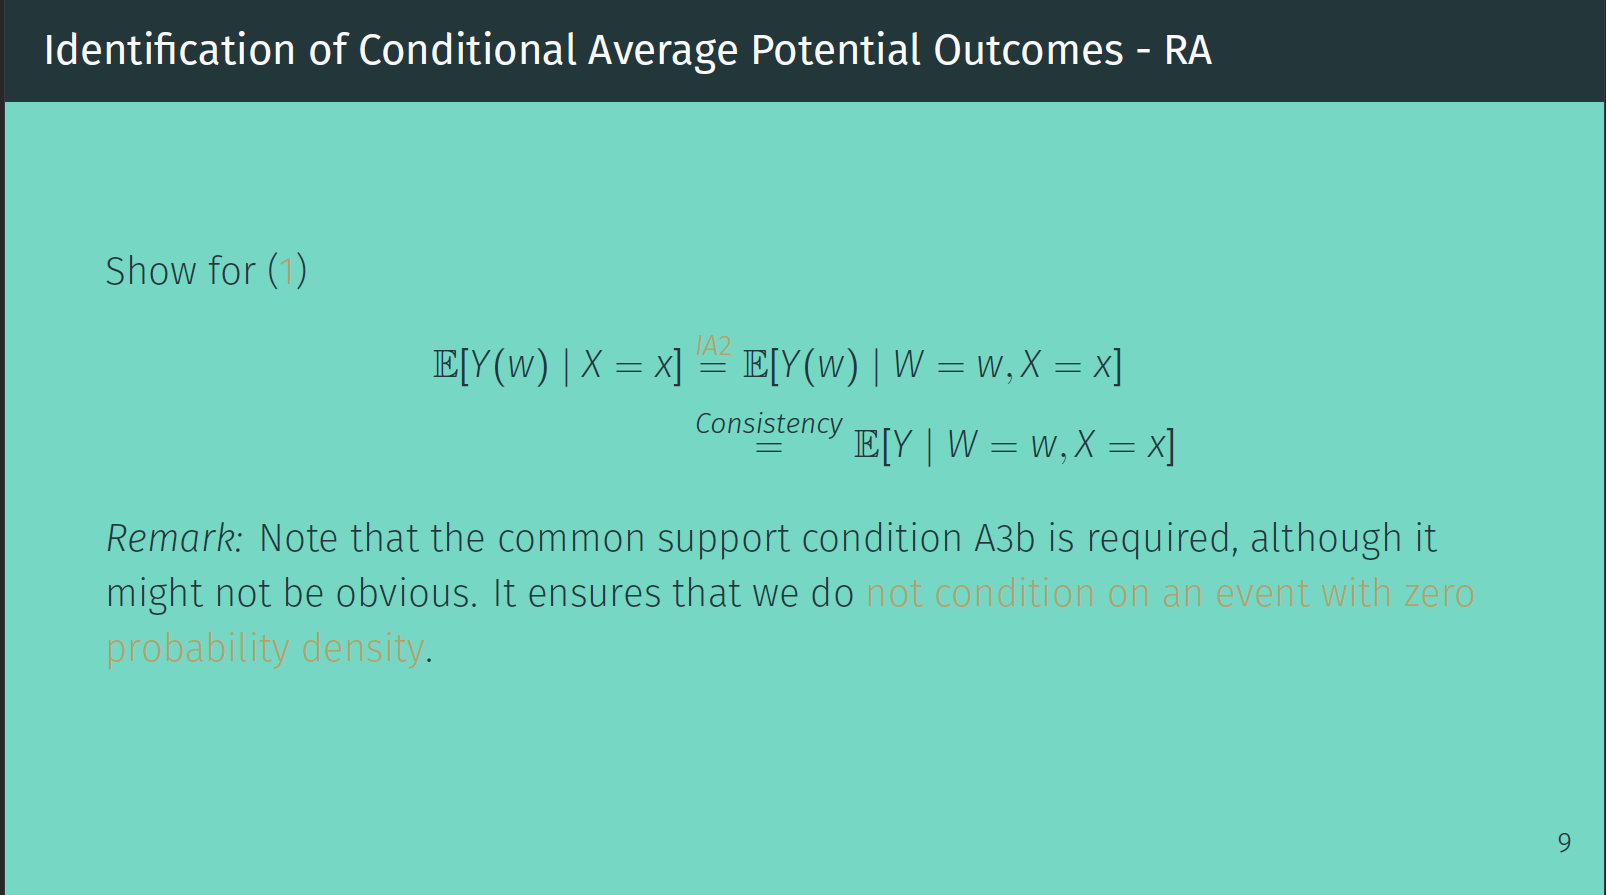

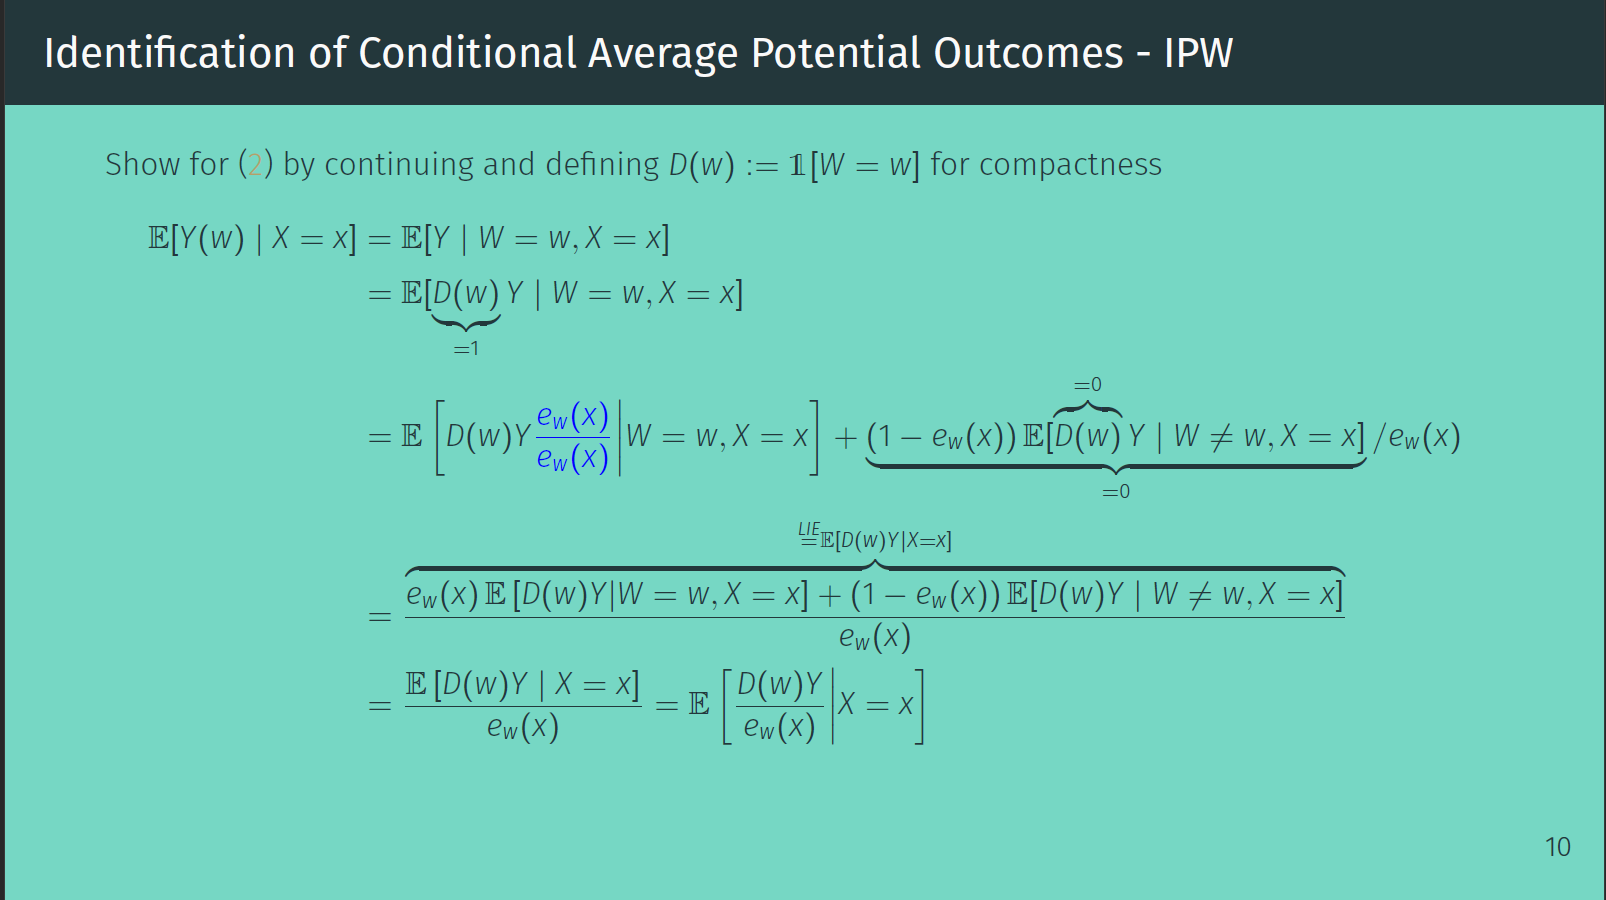

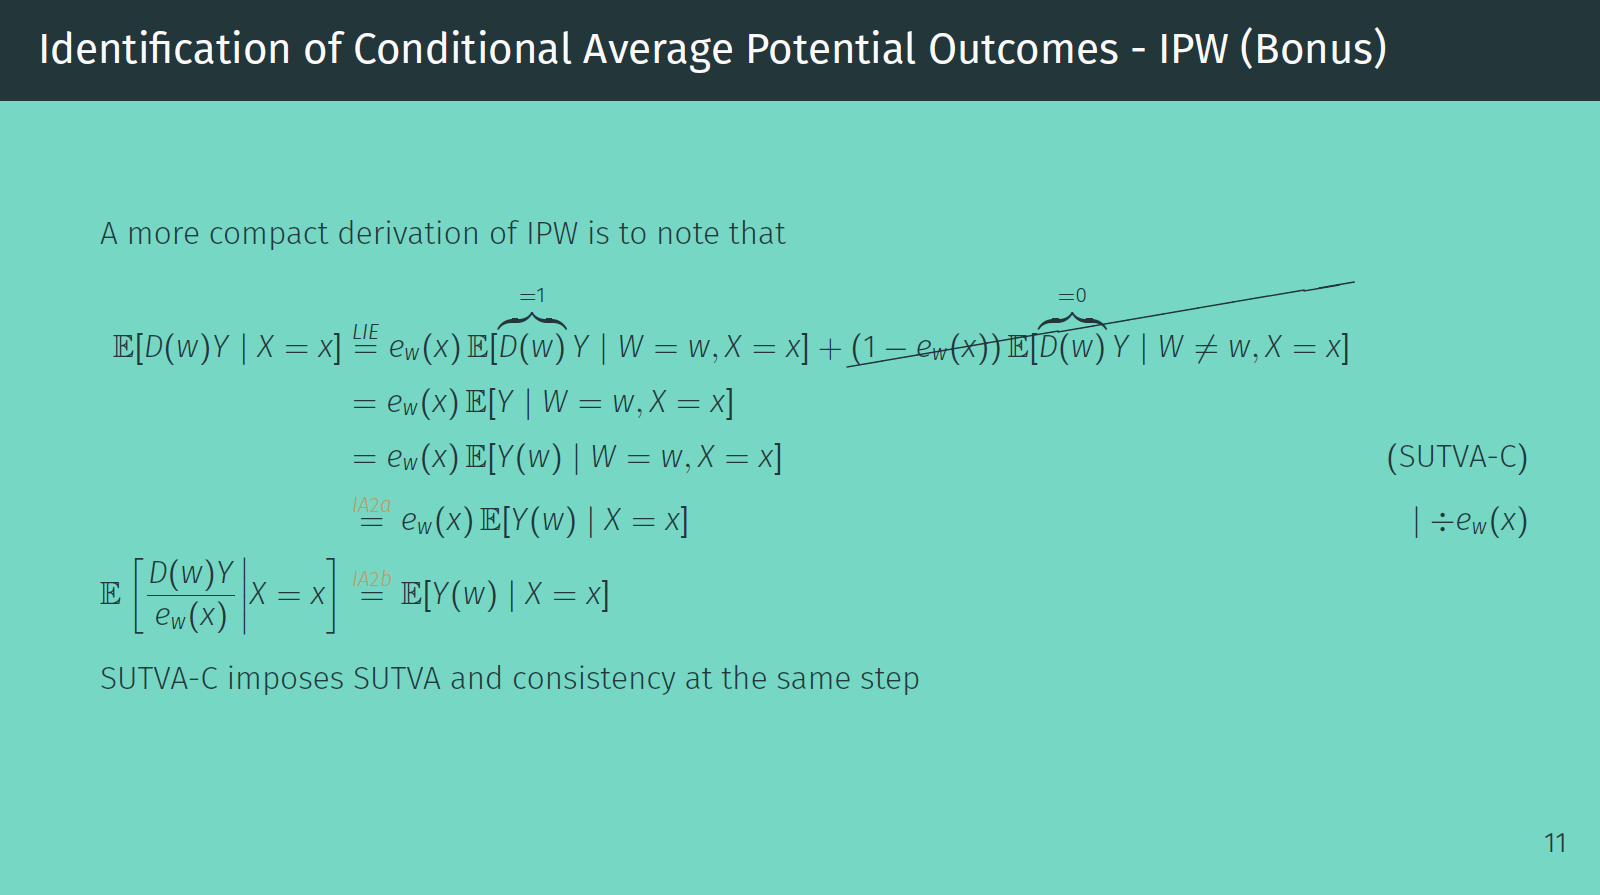

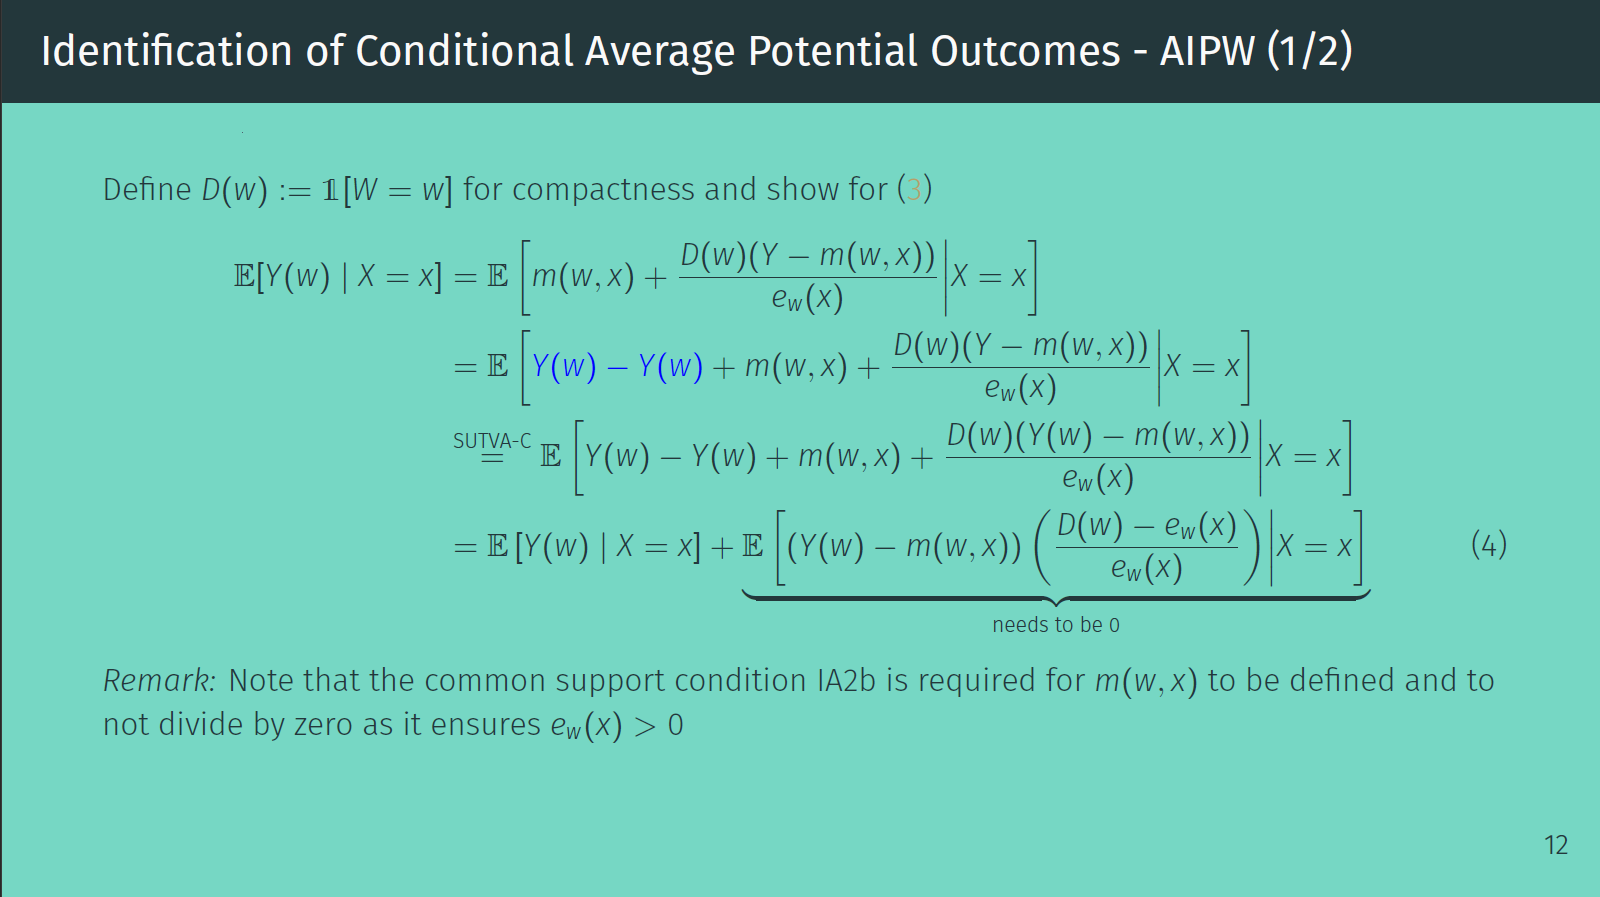

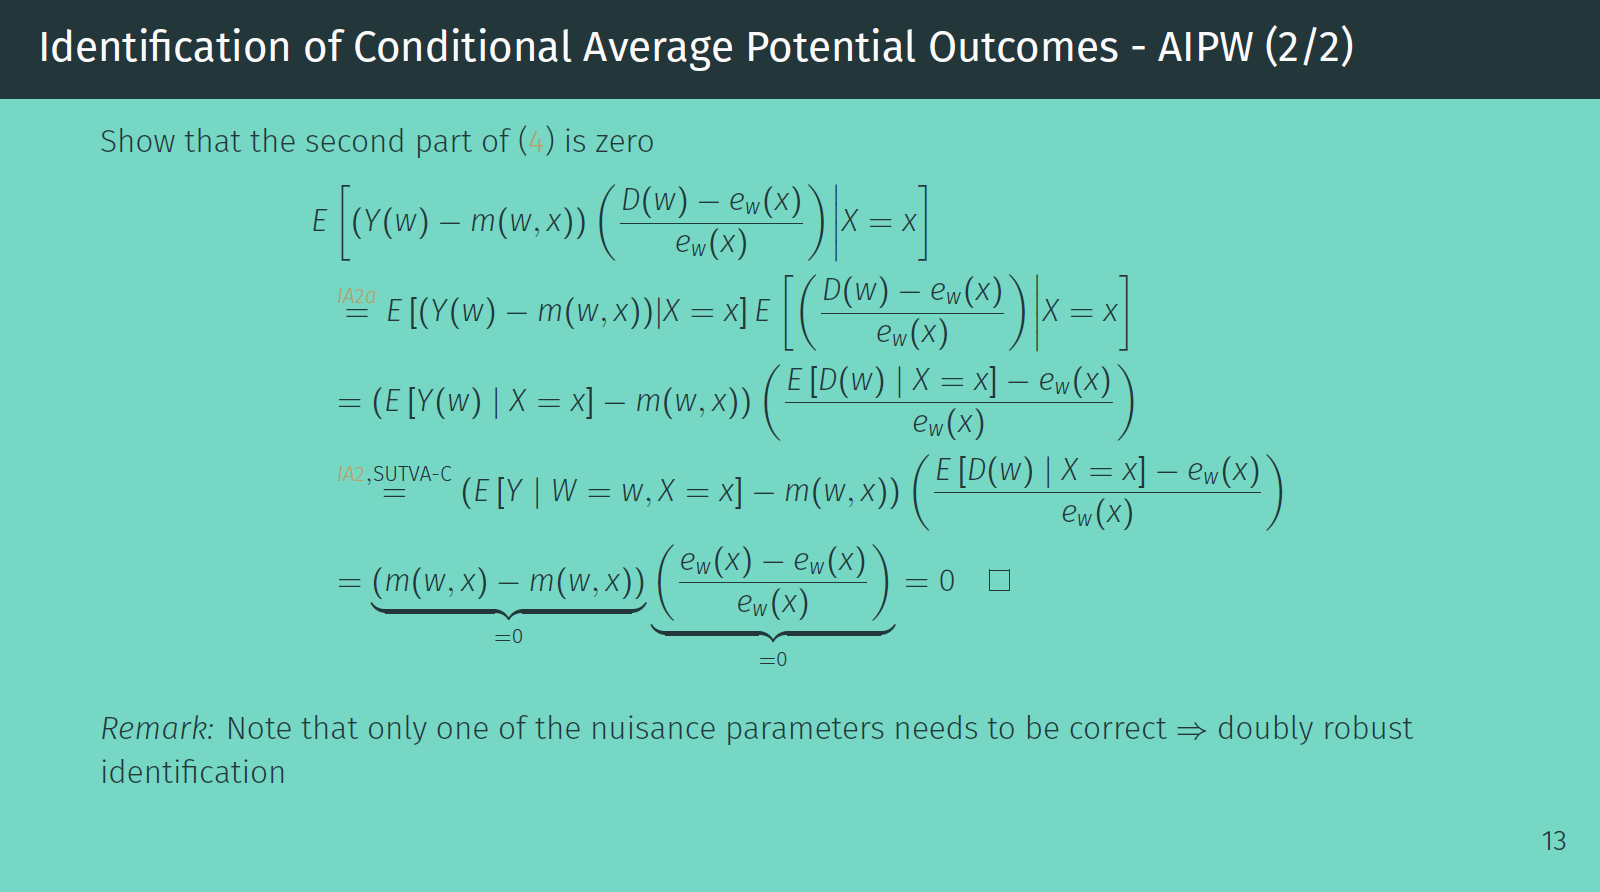

In [3]:
from IPython.display import display, Image

# Define file paths for the images
file_paths = [
r"C:\Users\feder\Desktop\Progetti Extra ML\Causal Machine Learning\5. Averaget treatment effect estimation - AIPW-DoubleML\RA.png",
r"C:\Users\feder\Desktop\Progetti Extra ML\Causal Machine Learning\5. Averaget treatment effect estimation - AIPW-DoubleML\IPW.png",
r"C:\Users\feder\Desktop\Progetti Extra ML\Causal Machine Learning\5. Averaget treatment effect estimation - AIPW-DoubleML\IPW 2.png",
r"C:\Users\feder\Desktop\Progetti Extra ML\Causal Machine Learning\5. Averaget treatment effect estimation - AIPW-DoubleML\AIPW.png",
r"C:\Users\feder\Desktop\Progetti Extra ML\Causal Machine Learning\5. Averaget treatment effect estimation - AIPW-DoubleML\AIPW 2.png"
]

# Define width and height for each image
width = 800
height = 600

# Create a list to store Image objects
images = []

# Load and display each image
for file_path in file_paths:
    image = Image(filename=file_path, width=width, height=height)
    images.append(image)

# Display images side by side
display(*images)

<div style="text-align:center;">

$$
\begin{align*}
1. & \quad \hat{RA}_w = \frac{1}{N} \sum_{i} \hat{m}(w; X_i) \\
2. & \quad \hat{IPW}_w = \frac{1}{N} \sum_{i} \frac{\mathbb{1}[W_i = w]Y_i}{\hat{e}_w(X_i)} \\
3. & \quad \hat{AIPW}_w = \frac{1}{N} \sum_{i} \left[ \hat{m}(w; X_i) + \frac{\mathbb{1}[W_i = w](Y_i - \hat{m}(w; X_i))}{\hat{e}_w(X_i)} \right] 
\end{align*}
$$
</div>

In [4]:
np.random.seed(21)

# Data Generating Process

def create_data(N=200,min_prob=0.2, max_prob=0.8):
    df = pd.DataFrame({'X1': np.random.uniform(0, 10, size=N)})
    df['X2'] = np.random.uniform(1, 2, size=N)
    
    prob_w_1 = df['X2'] - 1 

    prob_w_1 = np.clip(prob_w_1, min_prob, max_prob) 

    for i, p in enumerate(prob_w_1):
        df.at[i, 'W'] = np.random.choice([0, 1], p=[1 - p, p])
    
    df['epsilon'] = np.random.normal(size=N)
    df['Y'] = 2 * df['W'] + df['X1'] + 0.5 * np.exp(df['X2']) + df['epsilon']
    
    return df

df = create_data(20000, min_prob=0.2, max_prob=0.8)

$$
Y(w) = 2W + X_1 + 0.5 e^{X_2} + U_{Y(w)} \quad \text{(True model)}
$$

$$
X_1 \sim \mathbb{U}(0,10)
$$
$$
X_2 \sim \mathbb{U}(1,2)
$$
$$
W \sim \textit{Bernoulli (p), where p = $X_2$ -1} \quad \text{(however p is boundend between 0.2 and 0.8)}
$$
$$
U_{Y(w)} \sim \mathbb{N}(0,I_n)
$$

In [5]:
# Get an idea of the dataset
df.head()

,X1,X2,W,epsilon,Y
0,0.487249,1.058928,0.0,0.048359,1.977247
1,2.891097,1.373102,1.0,0.837950,7.702836
2,7.209663,1.357057,0.0,-1.233637,7.918397
3,0.216162,1.395637,0.0,-1.121407,1.113528
4,2.059228,1.246864,0.0,-0.786552,3.012383


<div style="text-align:center;">

**AIPW Double ML proceeds as follows:**

$$
\begin{align*}
1. & \quad \text{Form cross-fitted predictions of} \quad  \hat{m}(w; X) \quad  \text{and}  \quad \hat{e}_w(X) \quad \text{using ML methods.} \\

2. & \quad  \text{Create a pseudo-outcome} \quad \tilde{Y}_w =  \hat{m}(w; X) +  \frac{\mathbb{1}[W = w]\big(Y - \hat{m}(w; X)\big)}{\hat{e}_w(X)} \\

3. & \quad \text{Estimate APO as the mean of the pseudo-outcome} \quad  \hat{AIPW}_w = \frac{1}{N} \sum_{i} \tilde{Y}_{i,w}  \\

4. & \quad \text{Run t-test on the mean for hypothesis testing (no adjustments needed).}
\end{align*}
$$
</div>


\begin{aligned}
\tilde{Y}_{\text {ATE }} & =\tilde{Y}_{\gamma_1}-\tilde{Y}_{\gamma_0} \\
& =\underbrace{\hat{m}(1, X)-\hat{m}(0, X)}_{\text {outcome predictions }}+\underbrace{\frac{W(Y-\hat{m}(1, X))}{\hat{e}(X)}-\frac{(1-W)(Y-\hat{m}(0, X))}{1-\hat{e}(X)}}_{\text {weighted residuals }}
\end{aligned}

<div style="text-align:center;">

where we use that $\mathbb{1}[W=1]=W, \mathbb{1}[W=0]=1-W, e_1(X)=e(X)$, $e_0(X)=1-e(X)$
</div>

## Try AIPW by hand

In [6]:
# We're gonna use random forest to predict outcome, logistic regression to predict propensity score

random_forest_reg = RandomForestRegressor()
log_reg = LogisticRegression()

In [7]:
W = df['W']
X = df[['X1','X2']]

Y = df['Y']

In [8]:
# To predict the outcome we need two separete predictions for trated and controls

df_1 = df[df['W']==1]
df_0 = df[df['W']==0]

In [9]:
print(df_1.shape, df_0.shape)

(10048, 5) (9952, 5)


In [10]:
W1 = df_1['W']
X1 = df_1[['X1','X2']]

Y1 = df_1['Y']



W0 = df_0['W']
X0 = df_0[['X1','X2']]

Y0 = df_0['Y']

In [11]:
# Predict outcomes E[Y | X, W=w]

m_hat_1_treated = cross_val_predict(random_forest_reg, X1, Y1)
random_forest_reg.fit(X1,Y1)
m_hat_1_control = random_forest_reg.predict(X0)



m_hat_0_control = cross_val_predict(random_forest_reg, X0, Y0)
random_forest_reg.fit(X0,Y0)
m_hat_0_treated = random_forest_reg.predict(X1)

In [12]:
m_hat_0 = pd.concat([pd.Series(m_hat_0_control), pd.Series(m_hat_0_treated)], ignore_index=True)
m_hat_1 = pd.concat([pd.Series(m_hat_1_control), pd.Series(m_hat_1_treated)], ignore_index=True)

In [13]:
print(m_hat_0.shape, m_hat_1.shape)

(20000,) (20000,)


In [14]:
# Predict propensity scores E[W | X]

predictions = cross_val_predict(log_reg, X, W,  method='predict_proba')

e_hat = predictions[:, 1]


In [15]:
# Add the estimates of outcomes (treated and control) and propensity scores to the original dataset

df['m_hat_0']= m_hat_0
df['m_hat_1']= m_hat_1

df['e_hat'] = e_hat



In [16]:
# How the dataset looks now

df.head()

,X1,X2,W,epsilon,Y,m_hat_0,m_hat_1,e_hat
0,0.487249,1.058928,0.0,0.048359,1.977247,1.570733,3.754258,0.162354
1,2.891097,1.373102,1.0,0.837950,7.702836,9.176485,11.014713,0.387707
2,7.209663,1.357057,0.0,-1.233637,7.918397,2.922753,4.013198,0.370654
3,0.216162,1.395637,0.0,-1.121407,1.113528,3.465357,6.458187,0.409904
4,2.059228,1.246864,0.0,-0.786552,3.012383,1.823377,2.513794,0.282315


In [17]:
# Check how many propensity scores we have ==0 or ==1 (Note that if we have at least one e(X)==0 then we are done)

counts = df['e_hat'].value_counts()
if 0 in counts.index:
    print(f"Number of 0s in 'e_hat': {counts[0]}")
else:
    print("No 0s found in 'e_hat'.")

if 1 in counts.index:
    print(f"Number of 1s in 'e_hat': {counts[1]}")
else:
    print("No 1s found in 'e_hat'.")



No 0s found in 'e_hat'.
No 1s found in 'e_hat'.


In [18]:
# Compute outcome predictions
outcome_predictions = df['m_hat_1'] - df['m_hat_0']

# Compute weighted residuals
weighted_residuals = (df['W'] * (df['Y'] - df['m_hat_1'])) / (df['e_hat']) - ((1 - df['W']) * (df['Y'] - df['m_hat_0'])) / (1 - df['e_hat'])

# Add outcome_predictions and weighted_residuals to dataframe
df['outcome_predictions'] = outcome_predictions
df['weighted_residuals'] = weighted_residuals

In [19]:
df['effect'] = df['outcome_predictions'] + df['weighted_residuals']

In [20]:
ate = df['effect'].mean()

print(ate)

2.0949243089179665


In [21]:
# OLS regression with only the constant

intercept = np.ones((20000,1))

model_AIPW = sm.OLS(df['effect'],intercept).fit()

print(model_AIPW.summary())

                            OLS Regression Results                            
Dep. Variable:                 effect   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 27 Mar 2024   Prob (F-statistic):                nan
Time:                        18:25:16   Log-Likelihood:                -75057.
No. Observations:               20000   AIC:                         1.501e+05
Df Residuals:                   19999   BIC:                         1.501e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0949      0.073     28.712      0.0